## In this notebook, we will be finetuning a domain specific translation model
1. Training script with FP16 (done)
2. Evaluating the result using BLEU score (done)\
https://www.youtube.com/watch?v=DejHQYAGb7Q
3. logging with weights and bias (done)
4. Conversion to onnx/TensorRT format/torchscript
    - marianMT (seq2seq are not supported for conversion to onnx or tensorRT)
5. Try with trainer - on TPU (another notebook on google mt5 small)


After the model has been trained, we will attempt to deploy the model hugggingface spaces


references:
1. https://github.com/huggingface/notebooks/blob/master/examples/translation.ipynb
2. https://towardsdatascience.com/machine-translation-evaluation-with-sacrebleu-and-bertscore-d7fdb0c47eb3
3. https://colab.research.google.com/github/patil-suraj/exploring-T5/blob/master/T5_on_TPU.ipynb#scrollTo=AsQB1Kpjlltp
4. https://github.com/huggingface/transformers/blob/master/examples/pytorch/translation/run_translation_no_trainer.py

## Installing the packages

In [1]:
!pip install sentencepiece
!pip install transformers
!pip install datasets
!pip install sacrebleu
!pip install wandb 

     |████████████████████████████████| 1.2 MB 16.2 MB/s 
     |████████████████████████████████| 3.3 MB 15.8 MB/s 
     |████████████████████████████████| 61 kB 489 kB/s 
     |████████████████████████████████| 895 kB 56.2 MB/s 
     |████████████████████████████████| 3.3 MB 22.3 MB/s 
     |████████████████████████████████| 596 kB 49.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 298 kB 14.5 MB/s 
     |████████████████████████████████| 132 kB 63.1 MB/s 
     |████████████████████████████████| 243 kB 66.5 MB/s 
     |████████████████████████████████| 1.1 MB 44.9 MB/s 
     |████████████████████████████████| 192 kB 57.3 MB/s 
     |████████████████████████████████| 271 kB 59.7 MB/s 
     |████████████████████████████████| 160 kB 44.2 MB/s 
     |████████████████████████████████| 90 kB 6.5 MB/s 
     |████████████████████████████████| 1.7

## Importing the data

In [2]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=13AUtxHb_AMkgo_jEi_XjIw_jr0A4cSTY' -O training_data.xlsx

--2021-12-15 09:52:04--  https://docs.google.com/uc?export=download&id=13AUtxHb_AMkgo_jEi_XjIw_jr0A4cSTY
Resolving docs.google.com (docs.google.com)... 108.177.127.113, 108.177.127.139, 108.177.127.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.127.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/79ross0j6b5vv0chlm58bk3mrnkhsnih/1639561875000/13410031516798976466/*/13AUtxHb_AMkgo_jEi_XjIw_jr0A4cSTY?e=download [following]
--2021-12-15 09:52:08--  https://doc-08-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/79ross0j6b5vv0chlm58bk3mrnkhsnih/1639561875000/13410031516798976466/*/13AUtxHb_AMkgo_jEi_XjIw_jr0A4cSTY?e=download
Resolving doc-08-cc-docs.googleusercontent.com (doc-08-cc-docs.googleusercontent.com)... 173.194.69.132, 2a00:1450:4013:c04::84
Connecting to doc-08-cc-docs.googleusercontent.com (doc-08-

## Importing libraries

In [3]:
#numeric libraries
import numpy as np
import pandas as pd

#pytorch libraries
import torch
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast

#transformers libraries
import transformers
from transformers import (
    AutoTokenizer, 
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    default_data_collator,
    AdamW,
    get_cosine_schedule_with_warmup,
    get_linear_schedule_with_warmup
)
from datasets import load_metric

#plotting library
import matplotlib.pyplot as plt

#timing and looping 
from tqdm.notebook import tqdm

#sklearn libraries
from sklearn.model_selection import train_test_split

#python libraries
import os
import random

#wandb
import wandb

## logging in to wandb

In [4]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Config class

In [5]:
class config:
    #seed
    seed =42

    #metrics
    metrics_name = "sacrebleu"

    #dataset
    training_data_fp = "/content/training_data.xlsx"
    train_batchsize= 32
    val_batchsize = 32
    src_lang_col_name = "bahasa_broken"
    target_lang_col_name = "english_broken"
    max_src_lang_sentence_length = 104      #multiple of 8 as required by fp16
    max_target_lang_sentence_length = 104   #multiple of 8 as required by fp16
    dataloader_worker =2

    #model
    model_name = "Helsinki-NLP/opus-mt-id-en"
    generator_max_length = 104
    num_beams = None

    #optimizer
    optimizer = "AdamW"
    learning_rate = 5e-5

    #scheduler
    scheduler = "cosine" #cosine/linear
    warmup_ratio = 0.1

    #tokenizer
    label_pad_token_id = -100
    pad_to_max_length = False #false for dynamic batching, True for TPU

    #training params
    epochs = 8

    #fp16
    fp16 = True

    #debug
    debug = False

def convert_class_2_dict(class_name):
    storage = {}
    for name, value in config.__dict__.items():
        if not name.endswith("__"):
            storage[name] = value
    return storage


## Seed as much as possible

In [6]:
def seed_python(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

def seed_torch(seed):
    torch.manual_seed(seed)
    transformers.set_seed(seed)


seed_python(config.seed)
seed_torch(config.seed)

## Helper functions

In [7]:
def check_tokenized_sentence_length(data_list:list, tokenizer, is_target_lang=False, batch=64)->list:
    """
    This function takes in a np.array of sentence and returns the length of each tokenized sentence
    If we are training on a GPU, we can just use dynamic batching to minimize the number of padding but dynamic shape does not work well on TPU
    """
    N = len(data_list)
    sequence_length = []
    if not is_target_lang:
        for i in tqdm(range(0, N, batch)):
            sentences = data_list[i:i+batch]
            input_ids_batch = tokenizer(sentences)['input_ids']
            input_ids_len = [len(input_ids) for input_ids in input_ids_batch]
            sequence_length.extend(input_ids_len)
    else:
        with tokenizer.as_target_tokenizer():
            for i in tqdm(range(0, N, batch)):
                sentences = data_list[i:i+batch]
                input_ids_batch = tokenizer(sentences)['input_ids']
                input_ids_len = [len(input_ids) for input_ids in input_ids_batch]
                sequence_length.extend(input_ids_len)

    return sequence_length
        


## Reading the data, 
Checking the max sequence length and some preprocessing

In [8]:
training_data = pd.read_excel(config.training_data_fp)
print(f"length of training set {len(training_data)}")


training_data[config.src_lang_col_name] = training_data[config.src_lang_col_name].str.normalize("NFKC")
training_data[config.target_lang_col_name] = training_data[config.target_lang_col_name].str.normalize("NFKC")

training_data[config.src_lang_col_name] = training_data[config.src_lang_col_name].str.replace('“|”','"')
training_data[config.target_lang_col_name] = training_data[config.target_lang_col_name].str.replace('“|”','"')

training_data[config.src_lang_col_name] = training_data[config.src_lang_col_name].str.replace('|||`','')
training_data[config.target_lang_col_name] = training_data[config.target_lang_col_name].str.replace('|||`','')

training_data[config.src_lang_col_name] = training_data[config.src_lang_col_name].str.replace('–|—','-')
training_data[config.target_lang_col_name] = training_data[config.target_lang_col_name].str.replace('–|—','-')


training_data[config.src_lang_col_name] = training_data[config.src_lang_col_name].str.replace('ꞏ',' ')
training_data[config.target_lang_col_name] = training_data[config.target_lang_col_name].str.replace('ꞏ',' ')

training_data[config.src_lang_col_name] = training_data[config.src_lang_col_name].str.replace("’|‘","'").str.strip()
training_data[config.target_lang_col_name] = training_data[config.target_lang_col_name].str.replace("’|‘","'").str.strip()

training_data[config.src_lang_col_name] = training_data[config.src_lang_col_name].str.replace('\s{2,}',' ')
training_data[config.target_lang_col_name] = training_data[config.target_lang_col_name].str.replace('\s{2,}',' ')

training_data = training_data.dropna().reset_index(drop=True)

training_data.head()

length of training set 40862


,page,company,year,bahasa_broken,english_broken
0,14,TOWR,2020,Dengan penuh rasa syukur kami sampaikan kinerj...,"With gratitude, we are pleased to report that ..."
1,14,TOWR,2020,Tahun 2020 merupakan salah satu tahun dengan t...,2020 was a high growth year for us.
2,14,TOWR,2020,Kami menutup tahun 2020 dengan memiliki 21.381...,"We ended the year with 21,381 towers, 39,127 t..."
3,15,TOWR,2020,"Pada tahun 2020, penggunaan data melalui peran...","In 2020, wireless data traffic continue to inc..."
4,15,TOWR,2020,"Untuk tetap menjaga pertumbuhan, operator haru...","To maintain this growth, operators must contin..."


## Max sequence length of bahasa sentences

In [9]:
tokenizer = AutoTokenizer.from_pretrained(config.model_name)
bahasa_sentence_length = check_tokenized_sentence_length(training_data['bahasa_broken'].astype(str).tolist(), tokenizer)
english_sentence_length = check_tokenized_sentence_length(training_data['english_broken'].astype(str).tolist(), tokenizer, is_target_lang=True)

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/782k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/777k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

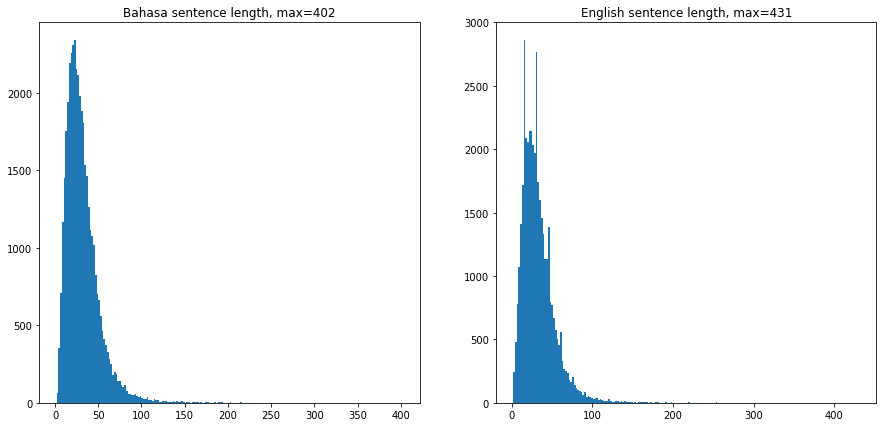

number of bahasa sentence above len 104 21
number of english sentence above len 104 25


In [10]:
## plotting to see the historgram
fig =plt.figure(figsize=(15, 7))
ax_1 = fig.add_subplot(1,2,1)
ax_1.hist(bahasa_sentence_length, bins=200)
ax_1.set_title(f"Bahasa sentence length, max={max(bahasa_sentence_length)}")
ax_2 = fig.add_subplot(1,2,2)
ax_2.hist(english_sentence_length, bins=200)
ax_2.set_title(f"English sentence length, max={max(english_sentence_length)}")
plt.show()

print(f"number of bahasa sentence above len 104 {sum(pd.Series(bahasa_sentence_length)>200)}")
print(f"number of english sentence above len 104 {sum(pd.Series(english_sentence_length)>200)}")

## Removing long sentences to reduce training time

In [11]:
training_data = training_data.loc[((pd.Series(bahasa_sentence_length)<=config.max_src_lang_sentence_length)) & 
                                  ((pd.Series(english_sentence_length)<=config.max_target_lang_sentence_length)) &
                                  (pd.Series(bahasa_sentence_length)>1) &
                                  (pd.Series(english_sentence_length)>1)]
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40413 entries, 0 to 40860
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   page            40413 non-null  int64 
 1   company         40413 non-null  object
 2   year            40413 non-null  int64 
 3   bahasa_broken   40413 non-null  object
 4   english_broken  40413 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.8+ MB


  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

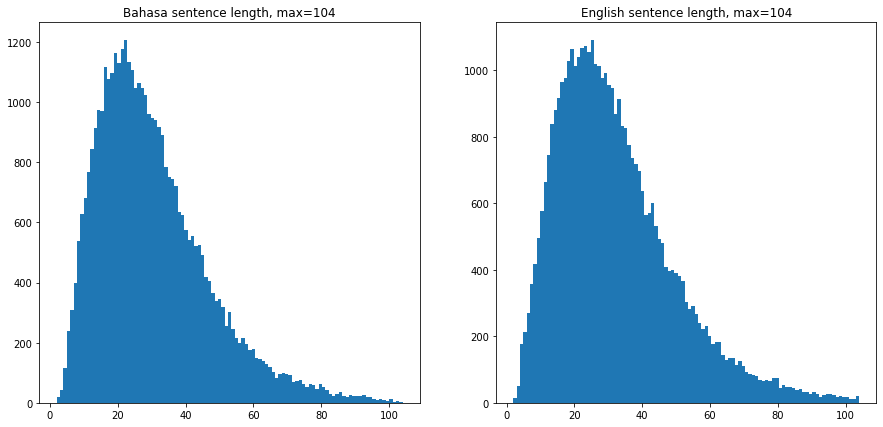

number of bahasa sentence above len 104 0
number of english sentence above len 104 0


In [12]:
bahasa_sentence_length = check_tokenized_sentence_length(training_data['bahasa_broken'].astype(str).tolist(), tokenizer)
english_sentence_length = check_tokenized_sentence_length(training_data['english_broken'].astype(str).tolist(), tokenizer, is_target_lang=True)
fig =plt.figure(figsize=(15, 7))
ax_1 = fig.add_subplot(1,2,1)
ax_1.hist(bahasa_sentence_length, bins=config.max_src_lang_sentence_length-1)
ax_1.set_title(f"Bahasa sentence length, max={max(bahasa_sentence_length)}")
ax_2 = fig.add_subplot(1,2,2)
ax_2.hist(english_sentence_length, bins=config.max_target_lang_sentence_length-1)
ax_2.set_title(f"English sentence length, max={max(english_sentence_length)}")
plt.show()

print(f"number of bahasa sentence above len 104 {sum(pd.Series(bahasa_sentence_length)>200)}")
print(f"number of english sentence above len 104 {sum(pd.Series(english_sentence_length)>200)}")

## Preprocess tokens as we are not doing any augmentations on the fly

In [ ]:
def preprocess_data(dataframe, tokenizer, config):
    src_lang_array = dataframe[config.src_lang_col_name].astype(str).to_numpy()
    target_lang_array = dataframe[config.target_lang_col_name].astype(str).to_numpy()
    padding_strategy = "max_length" if config.pad_to_max_length else False
    src_max_length = config.max_src_lang_sentence_length
    target_max_length = config.max_target_lang_sentence_length

    assert len(src_lang_array) == len(target_lang_array), "input and target array length does not match"
    total_examples = len(src_lang_array)
    model_inputs = []
    for src_lang, target_lang in tqdm(zip(src_lang_array, target_lang_array),total=total_examples):
        model_input = tokenizer(src_lang, max_length=src_max_length ,padding=padding_strategy, truncation=True)
        with tokenizer.as_target_tokenizer():
            target_sentence = tokenizer(target_lang, max_length=target_max_length, padding=padding_strategy,truncation=True)

        #if we are padding the sentences we should ignore the padding on the label by changing them to -100, to be ignored by bleu metrics
        if padding_strategy == 'max_length':
            target_sentence['input_ids'] = [(token if token != tokenizer.pad_token_id else -100) for token in target_sentence['input_ids']]

        model_input['labels'] = target_sentence['input_ids']
        model_inputs.append(model_input)

    return model_inputs

preprocessed_training_data = preprocess_data(training_data, tokenizer, config)

  0%|          | 0/40413 [00:00<?, ?it/s]

In [14]:
## verifying preprocessing
def convert_back_2_input_target(example, tokenizer):
    input_ids = example['input_ids']
    target_ids = example['labels']

    input = "".join(tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=True)).replace("▁", " ")
    with tokenizer.as_target_tokenizer():
        target = "".join(tokenizer.convert_ids_to_tokens(target_ids,skip_special_tokens=True)).replace("▁", " ")

    return input, target


## This step is very important as we are able to identify what other preprocessing is needed

In [15]:
for index in tqdm(range(len(preprocessed_training_data))):
    tokenized_input, tokenized_target = convert_back_2_input_target(preprocessed_training_data[index],tokenizer)
    tokenized_input = tokenized_input.strip()
    tokenized_target = tokenized_target.strip()
    original_input = training_data.iloc[index]['bahasa_broken']
    original_target = training_data.iloc[index]['english_broken']

    if original_input!=tokenized_input:
        print(original_input)
        print(tokenized_input)
        print("input mismatched")
       

    if original_target!=tokenized_target:
        print(original_target)
        print(tokenized_target)
        print("target mismatched")


  0%|          | 0/40413 [00:00<?, ?it/s]

## Training function

In [16]:
class TranslationDataset(Dataset):
    def __init__(self, data_list):
        super().__init__()
        self.data_list =data_list
    
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        return self.data_list[index]

class AverageMeter:
    def __init__(self):
        self.count = 0
        self.total = 0

    def update(self, val, count):
        self.count += count
        self.total += val*count

    def get_average(self):
        return self.total/self.count


def get_dataloader(train_list, val_list, tokenizer, model, config):
    if config.pad_to_max_length:
        data_collator = default_data_collator
    else:
        data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, 
                                               label_pad_token_id=config.label_pad_token_id, 
                                               pad_to_multiple_of=8)

    train_ds = TranslationDataset(train_list)
    val_ds = TranslationDataset(val_list)

    train_loader = DataLoader(train_ds, batch_size=config.train_batchsize, collate_fn=data_collator, shuffle=True, pin_memory=True,num_workers=config.dataloader_worker)
    val_loader = DataLoader(val_ds, batch_size=config.val_batchsize, collate_fn=data_collator, shuffle=False, pin_memory=True, num_workers=config.dataloader_worker)

    return train_loader, val_loader

def get_optimizer(model,config):
    if config.optimizer == 'AdamW':
        optimizer = AdamW(model.parameters(), lr = config.learning_rate)
    
    return optimizer

def get_scheduler(optimizer, train_step_per_epoch, config):
    num_training_steps  = train_step_per_epoch * config.epochs
    num_warmup_steps  = int(num_training_steps * config.warmup_ratio)

    if config.scheduler == "cosine":
        scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)
    elif config.scheduler=='linear':
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)    
    return scheduler

def get_model(config):
    model = AutoModelForSeq2SeqLM.from_pretrained(config.model_name)
    return model

def train_step(model, train_dataloader, optimizer, scheduler, config, device, scaler=None):
    model.train()
    loss_meter = AverageMeter()
    print("Training:")
    prog_bar = tqdm(range(len(train_dataloader)))

    if not config.fp16: 
        for batch in train_dataloader:
            batch_size = len(batch)
            batch = {k:v.to(device) for k, v in batch.items()} #move item to device
            outputs = model(**batch)
            loss = outputs.loss
            loss_meter.update(loss.item(), batch_size)
            loss.backward()

            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            prog_bar.update(1)
            prog_bar.set_postfix({"loss":loss_meter.get_average()})
    else:
        for batch in train_dataloader:
            batch_size = len(batch)
            batch = {k:v.to(device) for k, v in batch.items()} #move item to device
            with autocast():
                outputs = model(**batch)
                loss = outputs.loss
            loss_meter.update(loss.item(), batch_size)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()
            prog_bar.update(1)
            prog_bar.set_postfix({"loss":loss_meter.get_average()})
    
    return loss_meter.get_average()



def eval_step(model, val_dataloader, tokenizer, device, config):
    model.eval()
    print("Evaluation: ")
    prog_bar = tqdm(range(len(val_dataloader)))
    #loading metric
    metric = load_metric(config.metrics_name) # sacrebleu

    
    for batch in val_dataloader:
        batch = {k:v.to(device) for k, v in batch.items()}
        labels = batch['labels'].cpu().numpy()
        with torch.no_grad():
            generated_tokens = model.generate(batch['input_ids'], attention_mask=batch['attention_mask'], 
                                              max_length=config.generator_max_length, num_beams=config.num_beams).cpu().numpy()

        
            labels =  np.where(labels !=-100, labels, tokenizer.pad_token_id)    
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
            decoded_labels = [[label] for label in decoded_labels]
            decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

            metric.add_batch(predictions=decoded_preds,references=decoded_labels)

        prog_bar.update(1)
    score = metric.compute()['score']
    prog_bar.set_postfix({"bleu":score})

    return score

    


## Main training loop

In [ ]:
##initialize project in weight and biases
wandb.init(project="marianMT_finance_translation", entity="zuozhe")
wandb.config = convert_class_2_dict(config)

if config.debug:
    train_list, val_list = train_test_split(preprocessed_training_data[:20], train_size=0.9, shuffle=True, random_state=config.seed)
else:
    train_list, val_list = train_test_split(preprocessed_training_data, train_size=0.9, shuffle=True, random_state=config.seed)

#device selection
device = "cuda" if torch.cuda.is_available() else "cpu"

#loading pretrain model/tokenizer
tokenizer = AutoTokenizer.from_pretrained(config.model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(config.model_name)
model.to(device)

#creating dataloader
train_dataloader, val_dataloader = get_dataloader(train_list, val_list, tokenizer, model, config)

#create optimizer
optimizer = get_optimizer(model,config)

#get scheduler
train_steps_per_epoch = len(train_dataloader)
scheduler =get_scheduler(optimizer, train_steps_per_epoch, config)


#fp16 scaler
if config.fp16:
    scaler = GradScaler()
else:
    scaler = None

best_score = 0

for epoch in range(config.epochs):
    train_loss = train_step(model, train_dataloader, optimizer, scheduler, config, device, scaler)
    score = eval_step(model, val_dataloader, tokenizer, device, config)

    wandb.log({"training_loss":train_loss, "val_bleu_score":score})

    if score > best_score:
        best_score = score
        model.save_pretrained("/content/best_model")



wandb: Currently logged in as: zuozhe (use `wandb login --relogin` to force relogin)


Downloading:   0%|          | 0.00/278M [00:00<?, ?B/s]

Training:


  0%|          | 0/1137 [00:00<?, ?it/s]

Evaluation: 


  0%|          | 0/127 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Training:


  0%|          | 0/1137 [00:00<?, ?it/s]

Evaluation: 


  0%|          | 0/127 [00:00<?, ?it/s]

Training:


  0%|          | 0/1137 [00:00<?, ?it/s]

Evaluation: 


  0%|          | 0/127 [00:00<?, ?it/s]

Training:


  0%|          | 0/1137 [00:00<?, ?it/s]

Evaluation: 


  0%|          | 0/127 [00:00<?, ?it/s]

Training:


  0%|          | 0/1137 [00:00<?, ?it/s]

Evaluation: 


  0%|          | 0/127 [00:00<?, ?it/s]

Training:


  0%|          | 0/1137 [00:00<?, ?it/s]

Evaluation: 


  0%|          | 0/127 [00:00<?, ?it/s]

Training:


  0%|          | 0/1137 [00:00<?, ?it/s]

Evaluation: 


  0%|          | 0/127 [00:00<?, ?it/s]

In [ ]:
wandb.finish()